<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/lenet_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from google.colab import files
import helper

device_type = 'cpu'
if torch.cuda.is_available():
  device_type = 'cuda'

device = torch.device(device_type)
device

device(type='cuda')

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNetModern(d2l.Classifier):
  def __init__(self, num_classes=10, lr=0.1):
    super().__init__()
    self.lr = lr
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.LazyLinear(120),
        nn.ReLU(),
        nn.LazyLinear(84),
        nn.ReLU(),
        nn.LazyLinear(num_classes)
    )

  def forward(self, x):
    return self.net(x)

  def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
      X = layer(X)
      print(layer.__class__.__name__, "output shape = ", X.shape)

def get_loss(model, data):
  model.train = False

  losses, access = [], []
  for (inputs, outputs) in data.val_dataloader():
    preds = model.forward(inputs.to(device))
    loss = model.loss(preds, outputs.to(device)).item()
    acc = model.accuracy(preds, outputs.to(device)).item()
    losses.append(loss)
    access.append(acc)

  return np.mean(np.array(losses)), np.mean(np.array(access))

modern_model = LeNetModern()
data = d2l.FashionMNIST(batch_size=1000)
modern_model.layer_summary((1, 1, 28, 28))

Conv2d output shape =  torch.Size([1, 6, 28, 28])
ReLU output shape =  torch.Size([1, 6, 28, 28])
MaxPool2d output shape =  torch.Size([1, 6, 14, 14])
Conv2d output shape =  torch.Size([1, 6, 14, 14])
ReLU output shape =  torch.Size([1, 6, 14, 14])
MaxPool2d output shape =  torch.Size([1, 6, 7, 7])
Conv2d output shape =  torch.Size([1, 16, 3, 3])
ReLU output shape =  torch.Size([1, 16, 3, 3])
MaxPool2d output shape =  torch.Size([1, 16, 1, 1])
Flatten output shape =  torch.Size([1, 16])
Linear output shape =  torch.Size([1, 120])
ReLU output shape =  torch.Size([1, 120])
Linear output shape =  torch.Size([1, 84])
ReLU output shape =  torch.Size([1, 84])
Linear output shape =  torch.Size([1, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
files.upload_file('modern_lenet.pth')
modern_model =  LeNetModern(lr=0.1)
modern_model.load_state_dict(torch.load("modern_lenet.pth"))
get_loss(modern_model.to(device), data)

Saved modern_lenet.pth to /content/modern_lenet.pth


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(0.3283344805240631, 0.8822000384330749)

- Display the activations for different inputs

In [ ]:
global activations
activations = {}

def get_activation(name):
    def hook(module, inputs, output):
      global activations
      activations[name] = output
    return hook

list(modern_model.net.children())[2].register_forward_hook(get_activation('conv1'))
list(modern_model.net.children())[5].register_forward_hook(get_activation('conv2'))
list(modern_model.net.children())[8].register_forward_hook(get_activation('conv3'))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


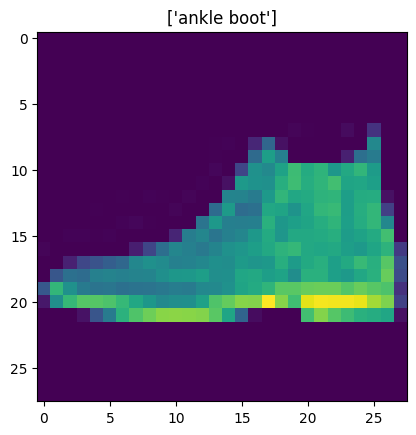

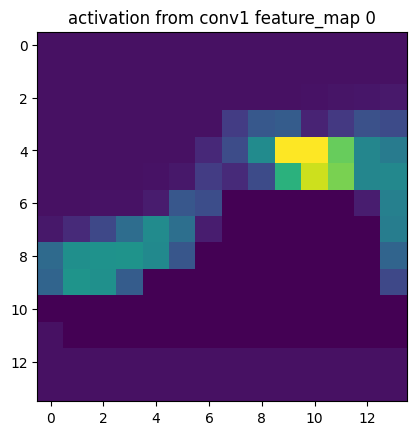

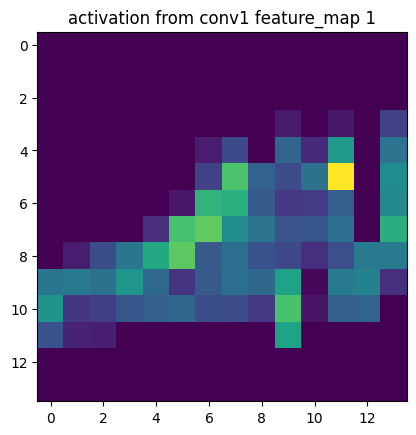

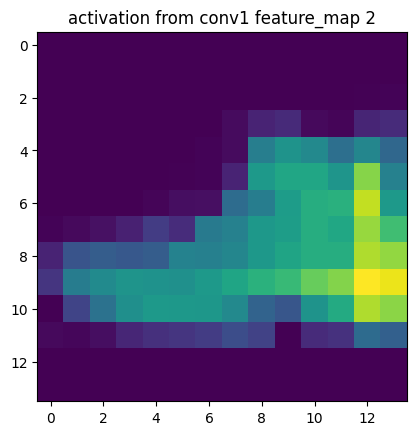

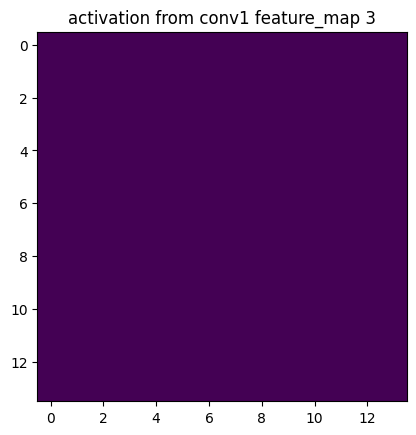

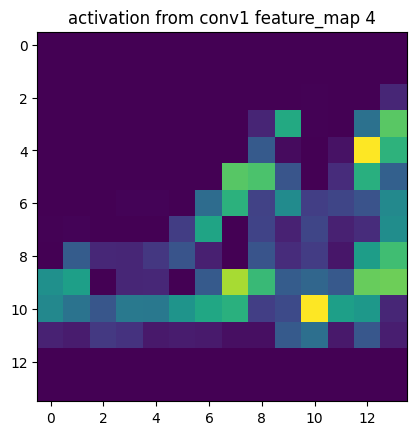

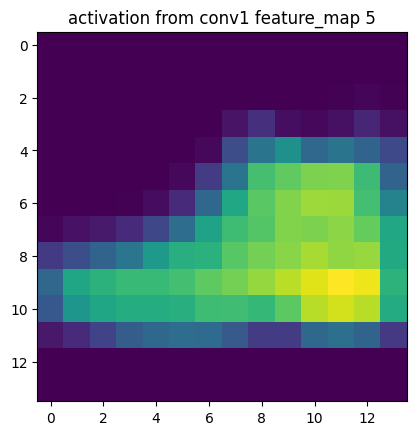

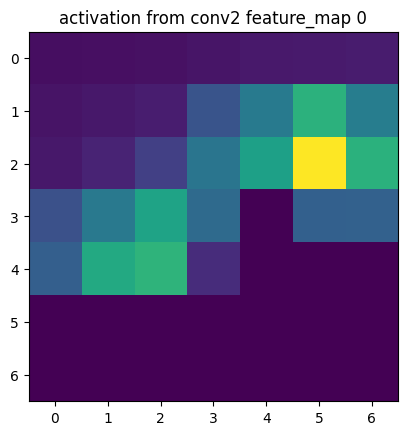

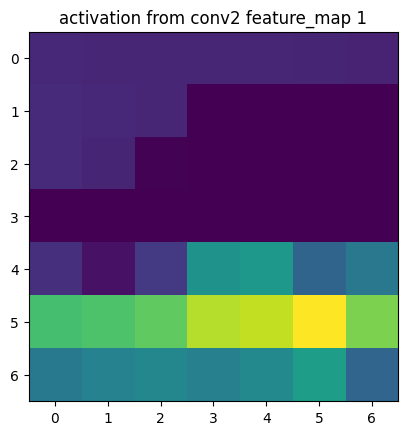

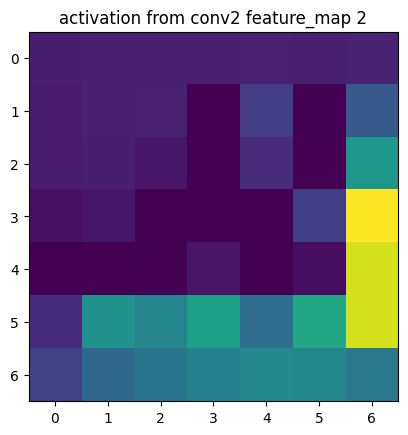

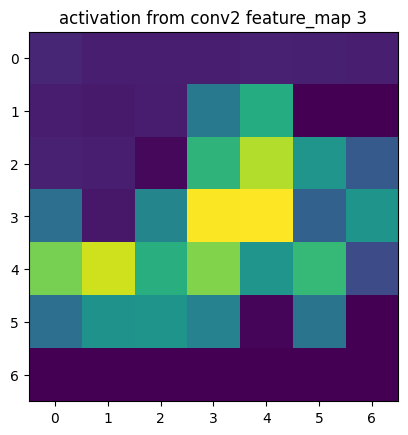

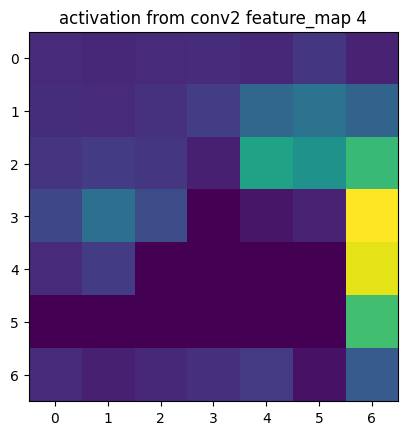

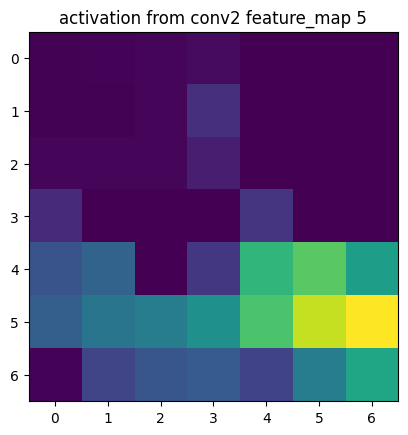

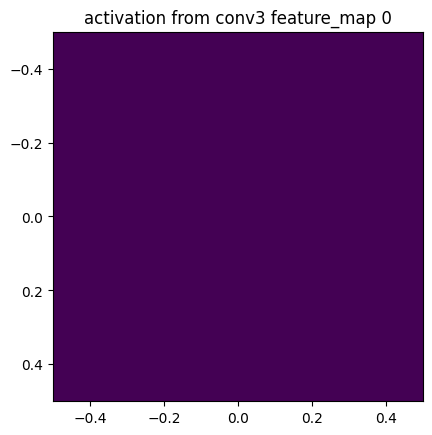

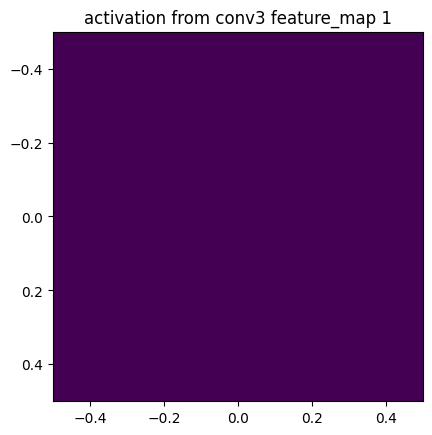

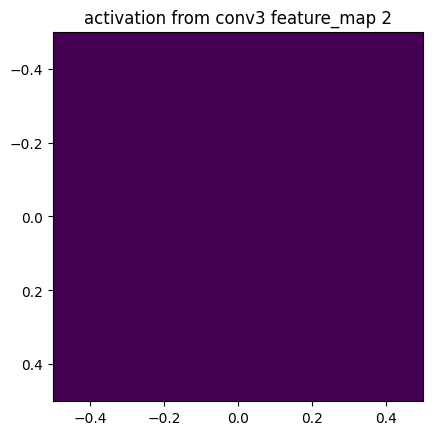

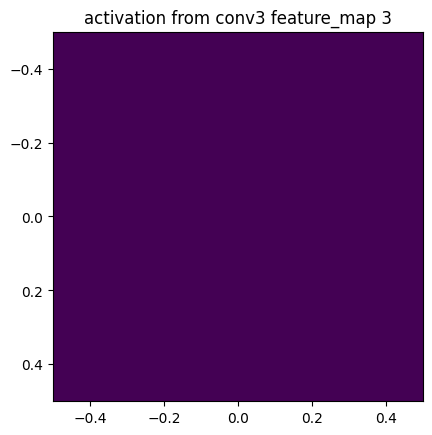

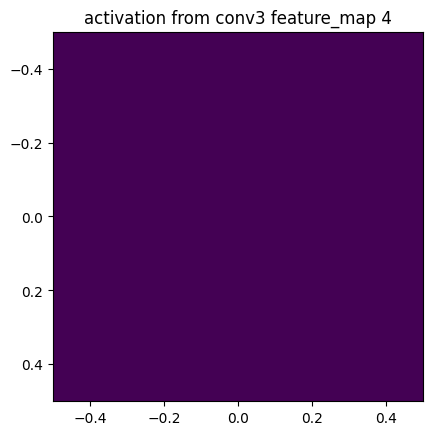

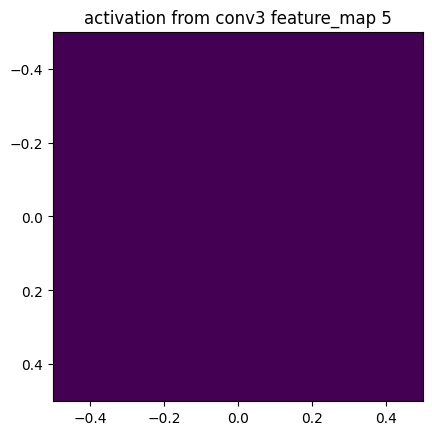

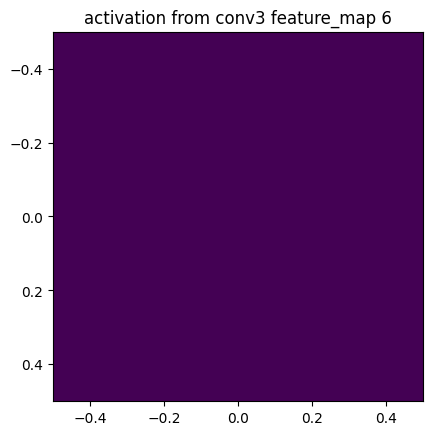

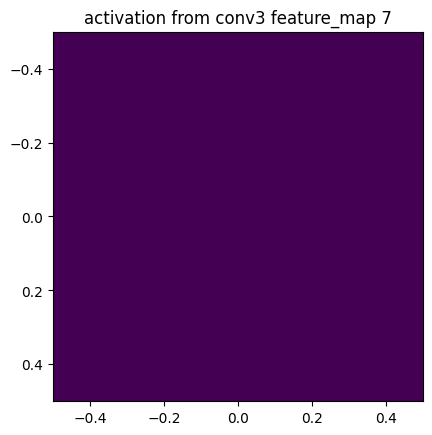

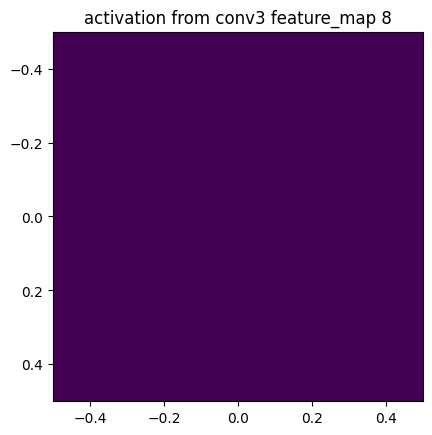

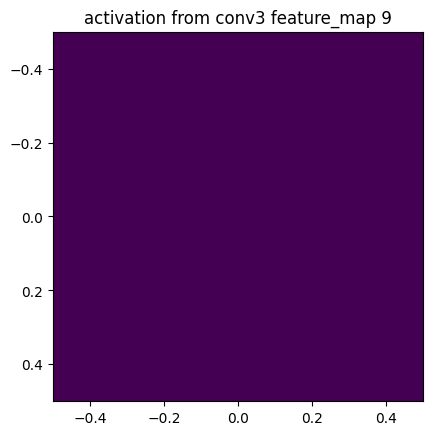

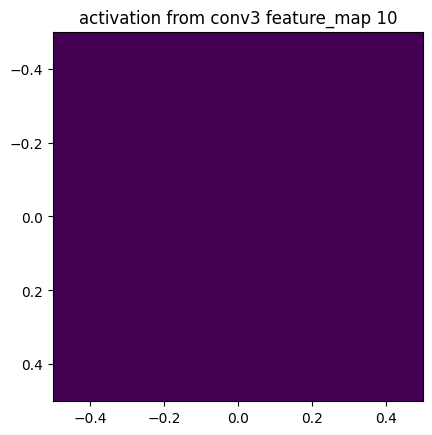

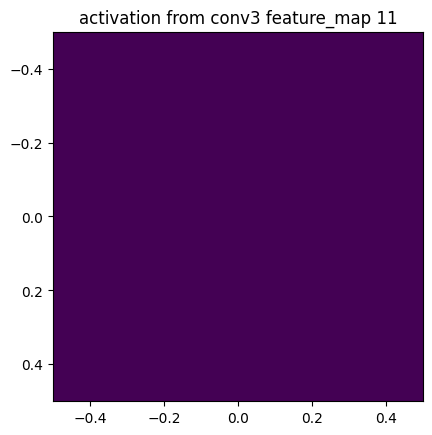

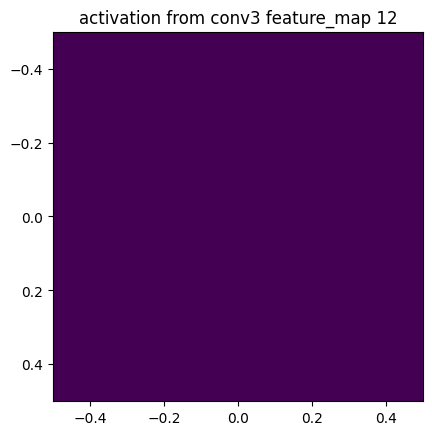

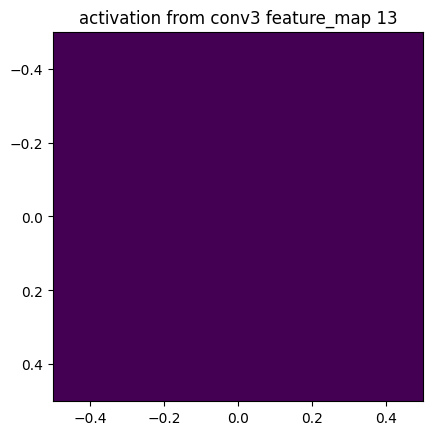

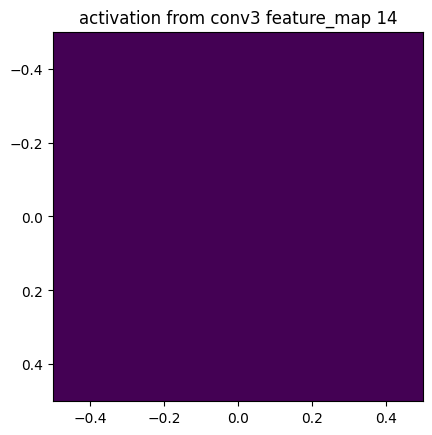

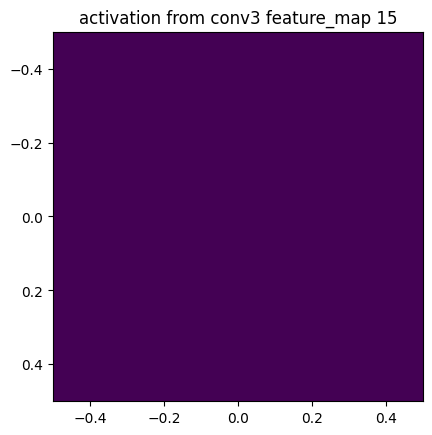

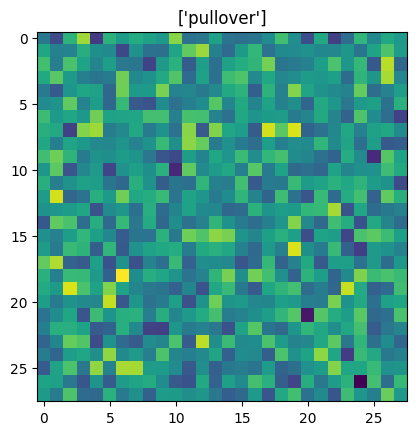

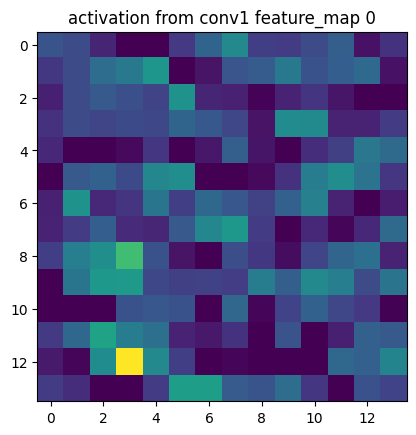

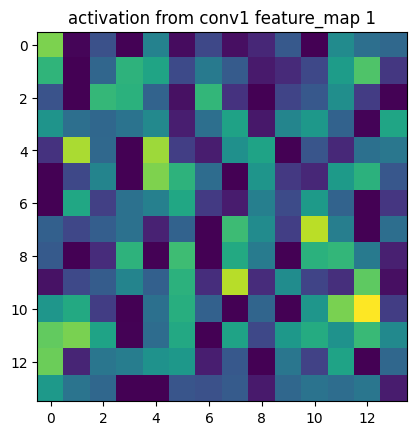

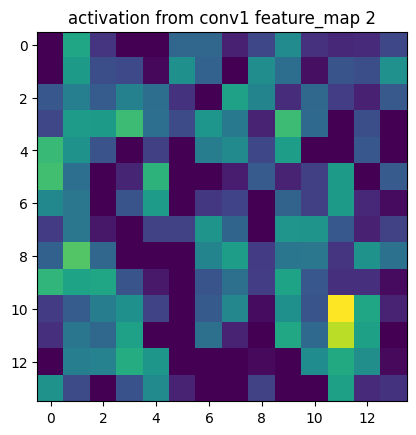

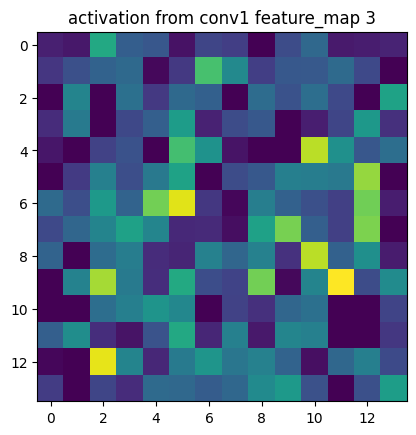

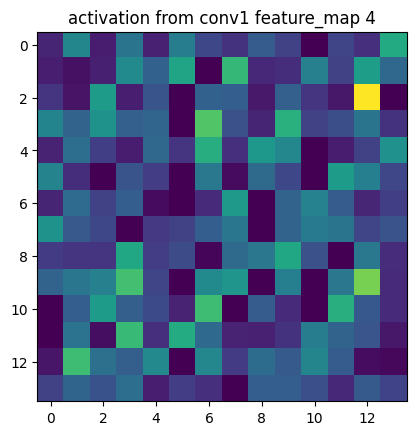

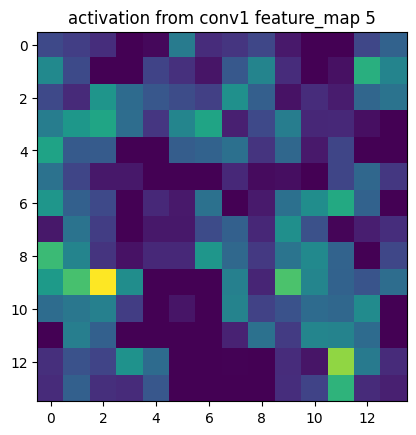

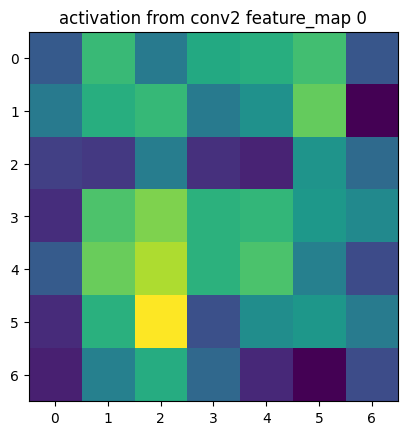

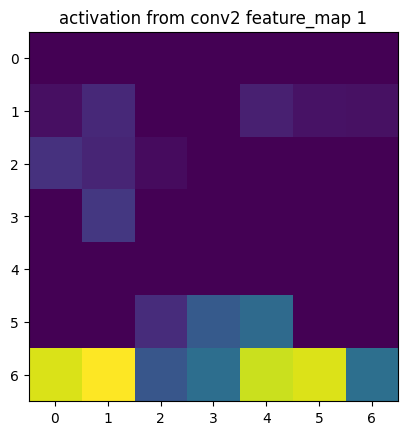

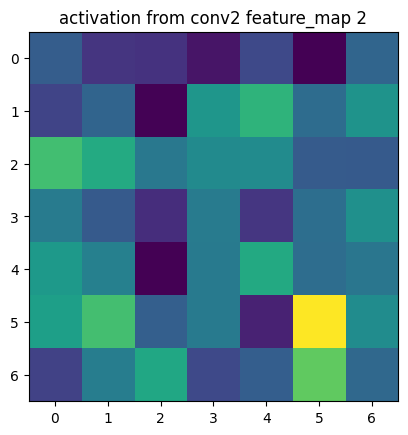

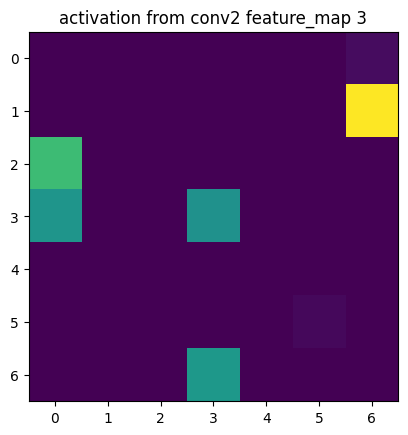

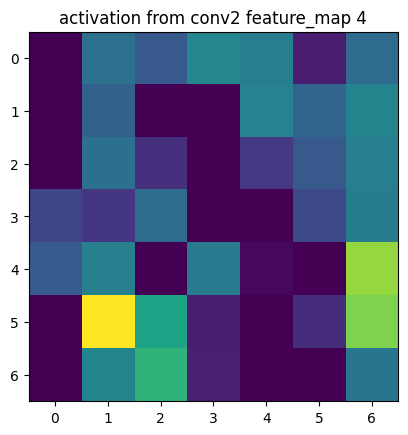

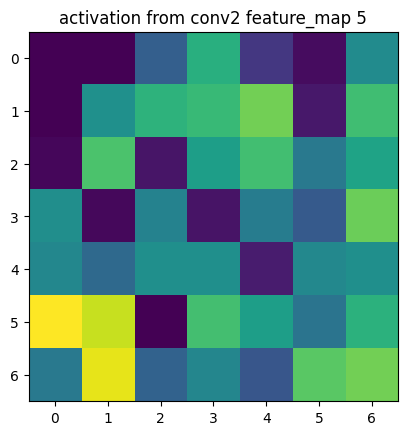

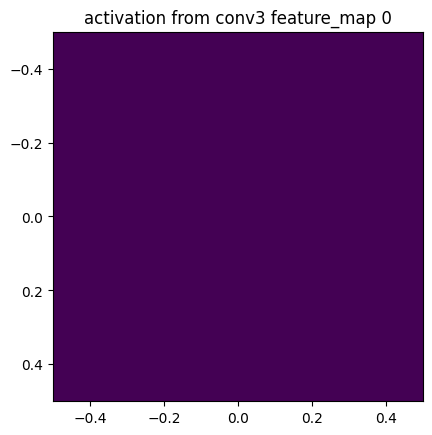

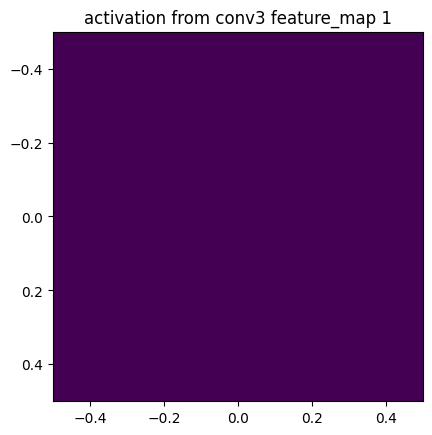

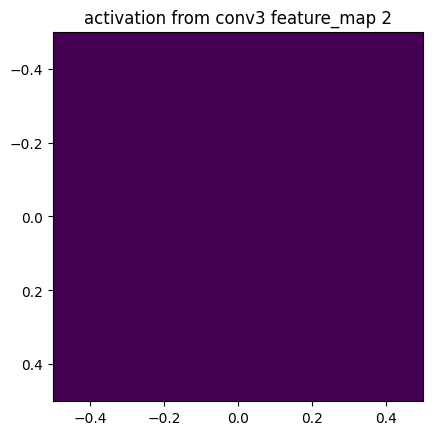

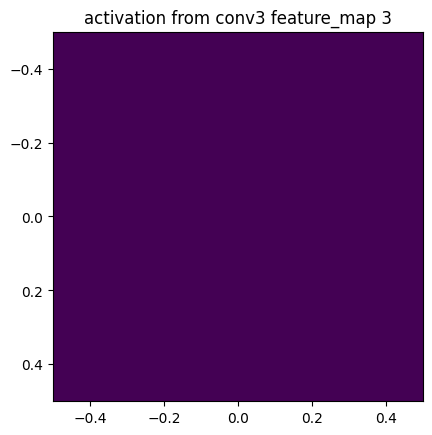

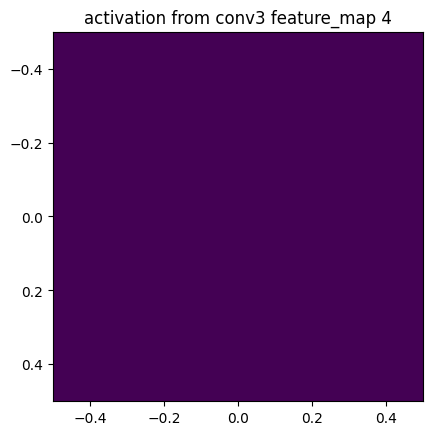

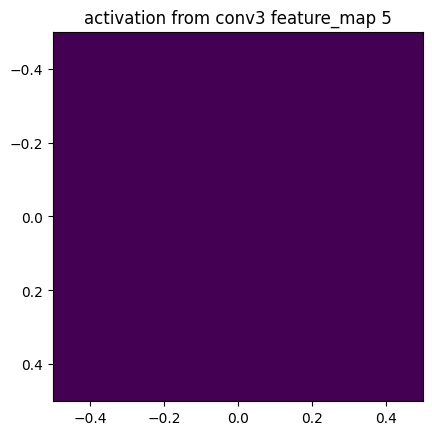

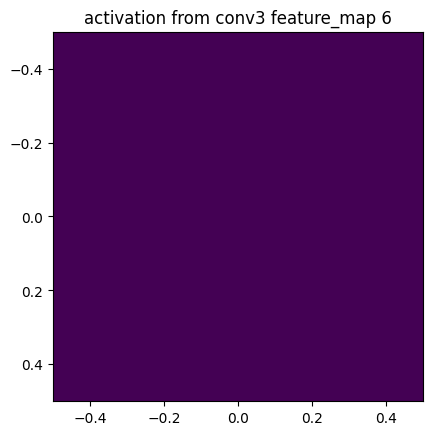

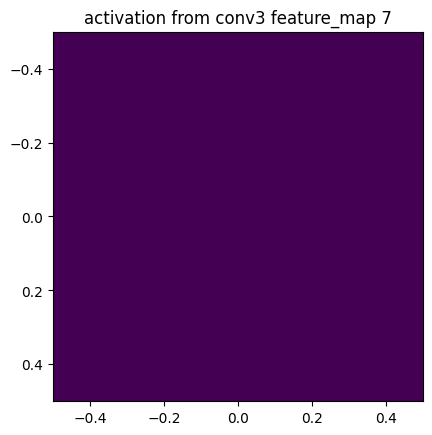

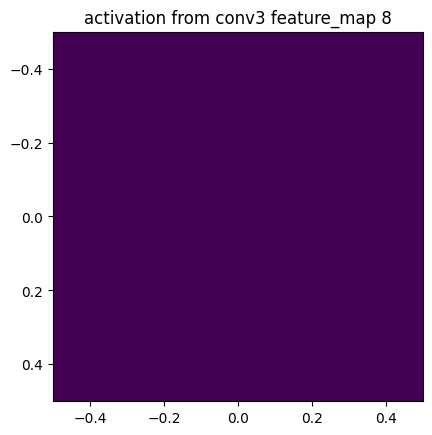

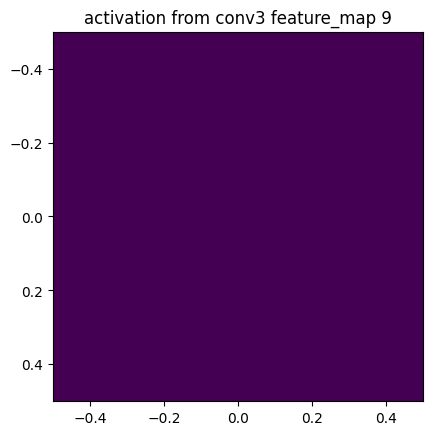

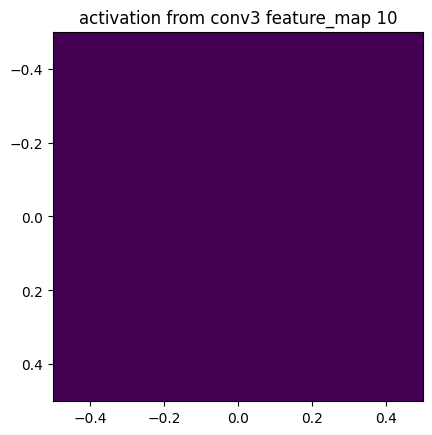

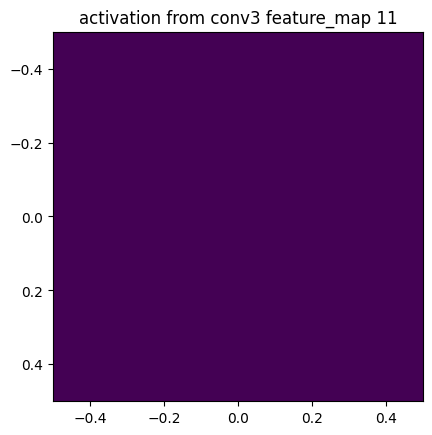

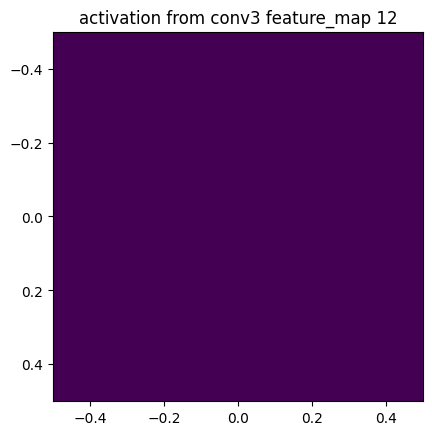

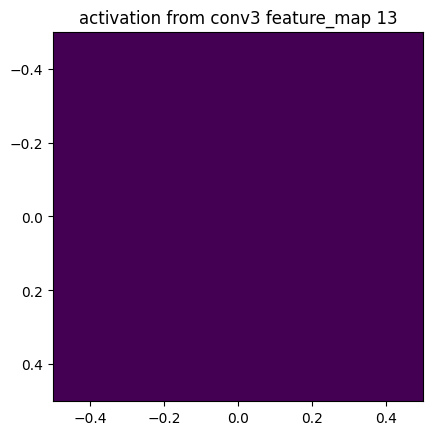

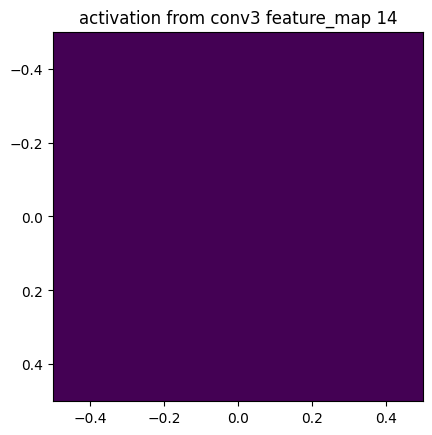

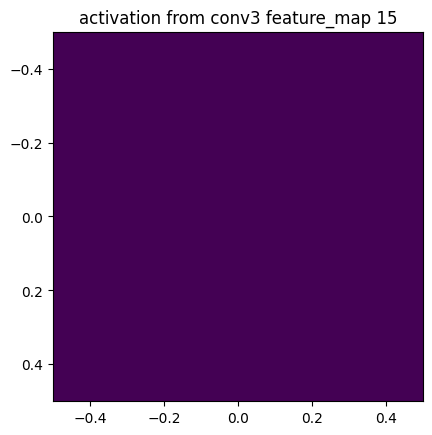

In [ ]:
from matplotlib import pyplot as plt

for (inputs, outputs) in data.val_dataloader():
  for i, (x, y) in enumerate(zip(inputs, outputs)):
    if i > 0:
      x = torch.randn(*x.shape)
    plt.imshow(x[0])
    plt.title(data.text_labels([y]))
    plt.show()
    _ = modern_model.forward(x.unsqueeze(dim=0).to(device))

    for layer in ['conv1', 'conv2', 'conv3']:
      for j, feature_map in enumerate(activations[layer][0]):
        plt.title(f'activation from {layer} feature_map {j}')
        plt.imshow(feature_map.detach().cpu().numpy())
        plt.show()


    if i >= 1:
      break
  break